In [1]:
import os
import collections
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
sys.path.append('..')
from settings import *
from loader.DBP15kRawLoader import DBP15kRawLoader, ENDBP15kRawLoader
from loader.DBP15KRawNeighbors import DBP15KRawNeighbors
from model.layers_LaBSE_neighbor import MyEmbedder, Trainer
from script.preprocess.deal_raw_dataset import MyRawdataset

LANGUAGE = 'fr_en'

Matplotlib created a temporary config/cache directory at /home1/data5/bowen/tmp/matplotlib-seg2_f_u because the default path (/home1/data5/bowen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def neighbor_dict(language, id_entity, num=1):
    id_neighbors_dict = {}
    filepath = PROJ_DIR + f'/data/DBP15K/{language}/triples_{num}'
    data = pd.read_csv(filepath, header=None, sep='\t')
    data.columns = ['head', 'relation', 'tail']

    for index, row in data.iterrows():
        head_str = id_entity[int(row['head'])]
        tail_str = id_entity[int(row['tail'])]
        # print(head_str)
        if not id_entity[int(row['head'])] in id_neighbors_dict.keys():
            id_neighbors_dict[id_entity[int(row['head'])]] = [head_str]
        if not tail_str in id_neighbors_dict[id_entity[int(row['head'])]]:
            id_neighbors_dict[id_entity[int(row['head'])]].append(tail_str)
        
        if not id_entity[int(row['tail'])] in id_neighbors_dict.keys():
            id_neighbors_dict[id_entity[int(row['tail'])]] = [tail_str]
        if not head_str in id_neighbors_dict[id_entity[int(row['tail'])]]:
            id_neighbors_dict[id_entity[int(row['tail'])]].append(head_str)
    return id_neighbors_dict


link = {}
f = 'test.ref'
link_data = pd.read_csv(join(join(DATA_DIR, 'DBP15K', LANGUAGE), f), sep='\t', header=None)
link_data.columns = ['entity1', 'entity2']
entity1_id = link_data['entity1'].values.tolist()
entity2_id = link_data['entity2'].values.tolist()
for i, _ in enumerate(entity1_id):
    link[entity1_id[i]] = entity2_id[i]
    link[entity2_id[i]] = entity1_id[i]

In [3]:
id_entity_1 = DBP15kRawLoader(language=LANGUAGE).id_entity
id_entity_2 = ENDBP15kRawLoader(language=LANGUAGE).id_entity
id_neighbors_dict1 = neighbor_dict(LANGUAGE, id_entity_1, num=1)
id_neighbors_dict2 = neighbor_dict(LANGUAGE, id_entity_2, num=2)

In [4]:
_num = []
for _id2 in entity2_id:
    _id1 = link[_id2]
    _num.append([len(id_neighbors_dict1[id_entity_1[_id1]])-1, len(id_neighbors_dict2[id_entity_2[_id2]])-1])

In [5]:
with open(FAIL_DIR + f'/{LANGUAGE}_num.pkl', 'rb') as f:
    at1_num, at10_num = pickle.load(f)

In [24]:
exec(f'{LANGUAGE}_all_num = np.array(_num)[:,0]')
en_all_num = np.array(_num)[:,1]
exec(f'{LANGUAGE}_at1_num = np.array(at1_num)[:,0]')
en_at1_num = np.array(at1_num)[:,1]
exec(f'{LANGUAGE}_at10_num = np.array(at10_num)[:,0]')
en_at10_num = np.array(at10_num)[:,1]

In [43]:
en_diff_at1 = np.copy(en_all_num).tolist()
for i in range(len(en_at1_num)):
    for item in en_diff_at1:
        if en_at1_num[i] == item:
            en_diff_at1.remove(item)
            break


In [44]:
import pandas as pd
at1_df = pd.DataFrame(en_diff_at1)
at1_bins = [i for i in range(0,200) if i%5==0 ]
at1_ = pd.cut(at1_df.values.flatten(), bins=at1_bins)
at1_.value_counts().values

array([1928, 5312, 1584,  515,  229,  131,   76,   49,   44,   43,   17,
         18,   15,   14,    4,    3,    4,    3,    4,    4,    3,    2,
          2,    2,    2,    2,    1,    2,    3,    3,    3,    6,    1,
          1,    1,    0,    0,    2,    1])

In [46]:
all_df = pd.DataFrame(en_all_num)
all_bins = [i for i in range(0,200) if i%5==0 ]
all_ = pd.cut(all_df.values.flatten(), bins=all_bins)
all_.value_counts().values+1

array([2042, 5507, 1649,  539,  245,  141,   88,   51,   48,   48,   19,
         22,   18,   17,    5,    4,    5,    4,    5,    6,    4,    4,
          3,    3,    3,    3,    2,    3,    5,    4,    4,    9,    2,
          2,    2,    1,    1,    3,    2])

In [47]:
at1_.value_counts().values / (all_.value_counts().values+1)

array([0.94417238, 0.96459052, 0.96058217, 0.9554731 , 0.93469388,
       0.92907801, 0.86363636, 0.96078431, 0.91666667, 0.89583333,
       0.89473684, 0.81818182, 0.83333333, 0.82352941, 0.8       ,
       0.75      , 0.8       , 0.75      , 0.8       , 0.66666667,
       0.75      , 0.5       , 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.5       , 0.66666667, 0.6       , 0.75      ,
       0.75      , 0.66666667, 0.5       , 0.5       , 0.5       ,
       0.        , 0.        , 0.66666667, 0.5       ])

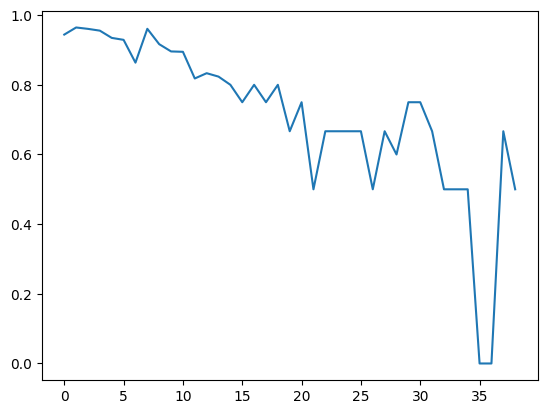

In [50]:
plt.figure()
x = pd.Series(at1_.value_counts().values / (all_.value_counts().values+1))
plt.plot(x)